In [1]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

### 1 signal

In [2]:
from distributions import total_pdf 


In [6]:
from generation import generate_from_total_pdf

true_params = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}
starting_params=true_params

N_events = 700
dataset = generate_from_total_pdf(N_events)

Unbinned
T: 55.9544309058025
True 7.3886511079680055 7.416289804496046e-14


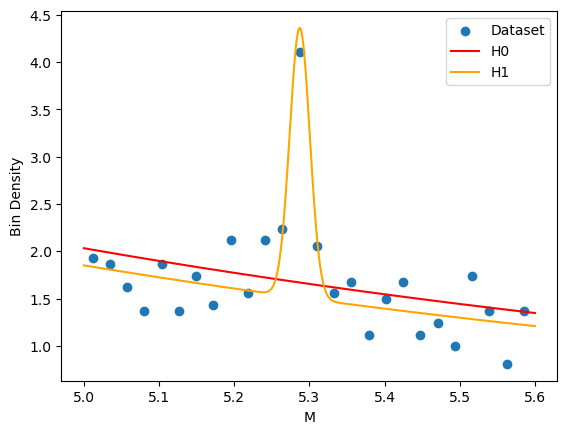

In [7]:
from distributions import total_cdf, total_pdf
from hypothesis_test import signal_background_test

starting_params={'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

print('Unbinned')
fig, discovery, Z, p_value = signal_background_test(
                                dataset, 
                                pdf=total_pdf,
                                cdf=total_cdf, 
                                starting_params=starting_params,
                                binned=False,
                                plot=True
                                )

print(discovery, Z, p_value)

Binned
T: 55.356324991663314
True 7.348014678502287 1.0058620603103918e-13


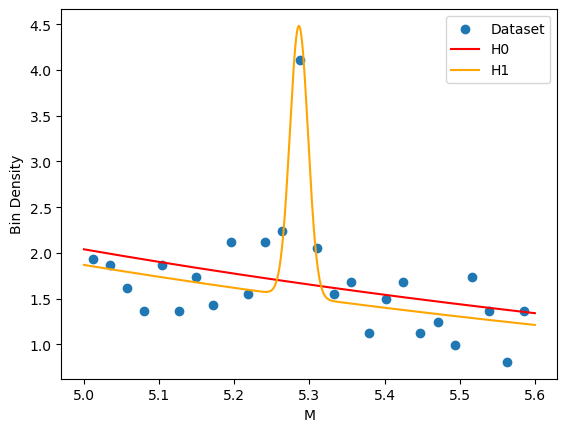

In [8]:
from distributions import total_cdf, total_pdf
from hypothesis_test import signal_background_test

starting_params={'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

print('Binned')
fig, discovery, Z, p_value = signal_background_test(
                                dataset, 
                                pdf=total_pdf,
                                cdf=total_cdf, 
                                starting_params=true_params,
                                binned=True,
                                plot=True
                                )

print(discovery, Z, p_value)

### 2 signal test

In [21]:
from generation import generate_from_two_signal_pdf

starting_params = {'f1': 0.1, 'f2': 0.05, 'lam': 0.5, 'mu1': 5.28, 'mu2': 5.35, 'sigma': 0.018}

N_events = 1000
two_signal_dataset = generate_from_two_signal_pdf(N_events)

T: 12.329828501589873
unbinned: False 3.322685182452882 0.00044577736028139636


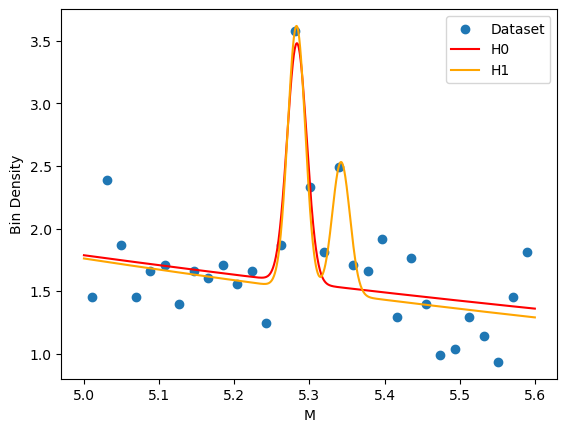

In [22]:
from hypothesis_test import two_signal_test
from distributions import two_signal_pdf, two_signal_cdf

fig, discovery, Z, p_value = two_signal_test(
                                two_signal_dataset,
                                pdf=two_signal_pdf,
                                cdf=two_signal_cdf,
                                starting_params=starting_params,
                                binned=False,
                                plot=True
                                )

print('unbinned:', discovery, Z, p_value)

T: 11.982861399002786
binned: False 3.270429907387985 0.0005369207529640763


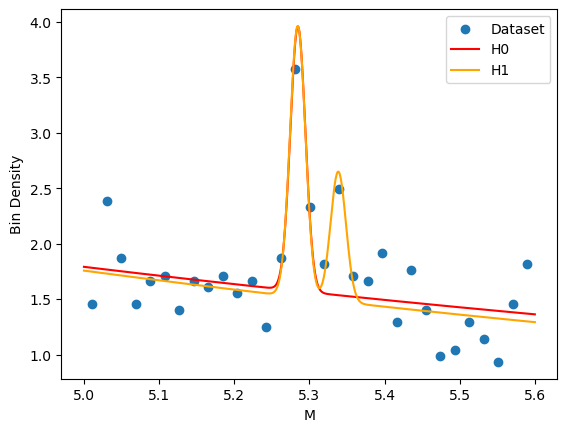

In [23]:
fig, discovery, Z, p_value = two_signal_test(
                                two_signal_dataset,
                                pdf=two_signal_pdf,
                                cdf=two_signal_cdf,
                                starting_params=starting_params,
                                binned=True,
                                plot=True
                                )

print('binned:', discovery, Z, p_value)